# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 2:
1. 18120625 - Nguyễn Trần Trung - [Trung-Rei](https://github.com/Trung-Rei)
2. 18120658 - Phạm Viết Xuân - [PhamVietXuan](https://github.com/PhamVietXuan)
3. 1712698 - Võ Văn Quân - [quanvovan](https://github.com/quanvovan)
4. 1712160 - Hà Thị Ngọc Thắm - [Thamha09081999](https://github.com/Thamha09081999)

Link thùng chứa Github của nhóm: [link](https://github.com/Trung-Rei/kaggle-porto-seguro)

## Mô tả bài toán

Bảo hiểm là một thứ bắt buộc khi mua một chiếc xe ô tô. Thông thường, mức chi phí đóng bảo hiểm sẽ bằng nhau. Nhưng có những người chạy xe cẩn thận, cũng có người chạy xe hay va chạm khiến cho chi phí đóng bảo hiểm cho người người như vậy không công bằng. Như vậy, cần có một mức giá khác nhau cho những người lái xe khác nhau để công bằng với khách hàng cũng như công ty bảo hiểm.

Porto Seguro - Một công ty bảo hiểm lớn ở Brazil yêu cầu một mô hình học máy tốt để dự đoán **xác suất yêu cầu bồi thường** của chủ xe nhằm đưa ra mức giá bảo hiểm hợp lý hơn.

Input/Output:
* Input: Dữ liệu lịch sử được công ty thu thập từ chủ ô tô (chủ hợp đồng bảo hiểm) từ các năm trước.
* Output: Xác suất chủ xe đó yêu cầu bồi thường bảo hiểm. Giá trị từ 0 - 1; càng về 0 có nghĩa khả năng cao chủ ô tô đó sẽ không yêu cầu bồi thường cho năm sau; càng về 1 nghĩa là chủ xe khả năng cao năm sau đòi bồi thường bảo hiểm.

Link bài toán: [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview)

### Độ đo đánh giá

* Metric: Normalized Gini Coefficient
* Cách tính: `2 * AUC – 1`
* Giá trị trong khoảng **(0, 1)**: càng về 1 mô hình càng tốt
* Phù hợp với bài toán phân lớp nhị phân và dữ liệu mất cân bằng nghiêm trọng (Giống **AUC**).

Giải thích cụ thể về **Normalized Gini Coefficient**: [link](https://luckytoilet.wordpress.com/2018/04/04/useful-properties-of-roc-curves-auc-scoring-and-gini-coefficients/?fbclid=IwAR1Md3U9Wk6E43cxV56NWxWroIGcRgGQJ7cnTZWJd9orSvbSYkiBcMhqxEs)

## Giải quyết bài toán

Solution nhóm chọn: [link](https://github.com/xiaozhouwang/kaggle-porto-seguro)

Tổng quan solution: Ensemble 2 mô hình LightGBM và Neural Networks. Mỗi mô hình có Feature engineering riêng. Kết quả cuối cùng lấy trung bình có trọng số của 2 mô hình.

Lý do chọn:
* Học được nhiều kỹ thuật FE thông dụng trên dữ liệu dạng bảng (feature crossing, feature interacting, feature selection,...).
* Học được cách làm việc trên data có đặc trưng ẩn danh (phổ biến trên thực tế).
* Sử dụng các mô hình LightGBM, XGBoost (là các mô hình được sử dụng rất nhiều trong các cuộc thi trên Kaggle).

Trong notebook này, nhóm tìm hiểu và code lại dựa trên mô tả và code mà tác giả cung cấp. Ở hầu hết các bước, tác giả không giải thích rõ ràng (sẽ chỉ ra bên dưới) thì nhóm cũng đã phân tích, thí nghiệm để làm rõ những kỹ thuật được tác giả sử dụng. Trong quá trình code lại thì nhóm có điều chỉnh một số chỗ để code phù hợp và dễ hiểu hơn (phần code lại sẽ được chú thích rõ ràng bên dưới).

### Import thư viện

Cho LightGBM

In [1]:
! pip install lightgbm==2.0.10

     |████████████████████████████████| 609 kB 14.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [2]:
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import lightgbm as lgbm # should install lightgbm 2.0.10
from google.colab import files

plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["font.size"] = 14
import warnings
warnings.filterwarnings("ignore")

Cho Neural Networks

In [4]:
files.upload() # Upload file util.py

{}

In [5]:
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, merge
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import numpy as np
import pandas as pd
from time import time
import datetime

from util import Gini, interaction_features, proj_num_on_cat
from itertools import combinations
from scipy import sparse

### Tổng quan dữ liệu

Thông tin dữ liệu từ cuộc thi được bảo mật nên tên các đặc trưng được thay thế bằng tên ẩn danh.

Các thông tin được cuộc thi cung cấp:
* Đặc trưng được chia làm 4 nhóm chính:
    * `ind` (individual): các đặc trưng liên quan đến người lái xe.
    * `reg` (region): các đặc trưng về khu vực người đó chạy xe.
    * `car` (car): các đặc trưng thông số của ô tô.
    * `calc` (calculated): các đặc trưng đã được tính toán.
* Hậu tố `cat` cho đặc trưng **categorical**, `bin` cho đặc trưng **nhị phân**, không có hậu tố chỉ những đặc trưng **ordinal** hoặc **continuous**.
* Giá trị `-1` đại diện cho dữ liệu tại đó bị thiếu.
* Cột `target`: gồm giá trị 1 và 0 thể hiện chủ xe đó có đưa ra yêu cầu bồi thường hay không.

*Phần này nhóm thực hiện một số khám phá nhỏ để nắm được tổng quan dữ liệu.*

In [7]:
files.upload() # Upload file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trntrungnguyn","key":"ec457be5ac670b699858b1acdf923bf3"}'}

In [6]:
! pip install kaggle

In [8]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle competitions download porto-seguro-safe-driver-prediction

  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 69.5MB/s]
 88% 39.0M/44.4M [00:01<00:00, 12.8MB/s]
100% 44.4M/44.4M [00:01<00:00, 36.8MB/s]
 30% 9.00M/30.0M [00:01<00:01, 11.7MB/s]
100% 30.0M/30.0M [00:01<00:00, 26.9MB/s]


In [12]:
! unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [13]:
! unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [14]:
path = "./"

train = pd.read_csv(path+'train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv(path+'test.csv')
test_id = test['id']

In [15]:
train.sample(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
329599,823613,0,3,1,9,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.3,0.0,0.696868,7,1,-1,0,-1,0,1,1,2,1,32,3,0.316228,0.618416,0.361525,2.828427,0.7,0.4,0.7,1,1,7,3,12,3,6,4,2,4,6,0,1,1,0,0,1
360031,899457,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,6,1,0,0,0.9,0.5,0.832541,7,0,0,0,0,10,1,1,2,1,83,2,0.399375,0.562591,0.337639,0.000000,0.1,0.3,0.2,1,1,8,2,10,0,4,6,0,5,12,0,0,0,1,0,1
341302,852611,0,0,1,2,1,0,0,1,0,0,0,0,0,0,0,3,0,0,1,0.9,1.4,1.563050,10,0,-1,0,1,10,1,1,0,1,28,3,0.387298,0.931142,0.382099,3.162278,0.5,0.2,0.4,1,1,8,5,8,3,7,5,2,2,3,0,0,1,0,0,0
167192,417827,0,1,1,7,1,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.7,0.2,0.787798,6,1,-1,0,1,1,1,1,0,1,38,2,0.316228,0.739461,0.359861,3.464102,0.8,0.3,0.9,2,1,10,1,7,0,14,5,2,5,9,0,1,1,0,0,0
264533,661009,0,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.6,1.0,1.003743,3,0,-1,0,-1,0,0,1,2,1,88,3,0.400000,0.812976,0.397492,3.162278,0.7,0.4,0.9,2,1,9,1,11,3,6,2,3,4,4,0,1,1,1,0,1


In [16]:
train.shape

(595212, 59)

In [17]:
test.shape

(892816, 58)

In [18]:
train.drop_duplicates()
train.shape

(595212, 59)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

0    0.963552
1    0.036448
Name: target, dtype: float64


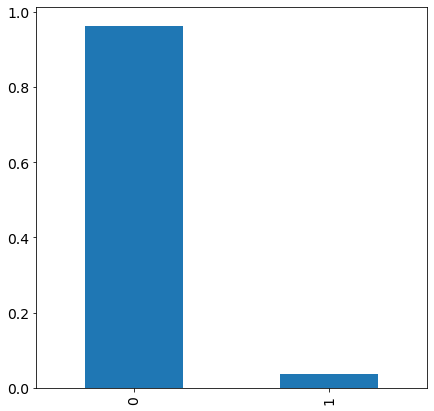

In [20]:
cls_ratio = train_label.value_counts()/train_label.count()
print(cls_ratio)
cls_ratio.plot.bar()
plt.show()

* Tập **train** có 59 cột, tập **test** có 58 cột (không có cột `target`)
* Tập **train** không có dòng trùng nhau.
* Toàn bộ dữ liệu đều ở dạng số.
* Dữ liệu mất cân bằng nghiêm trọng với `96.3%` lớp 0 và `3.6%` lớp 1.

### Feature engineer + Khám phá dữ liệu (LightGBM)

Bao gồm:
* Loại bỏ tất cả đặc trưng `calc`
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Mã hóa one hot với các đặc trưng `cat`
* Gộp các đặc trưng `ind` làm một: `new_ind` (feature crossing)
* Đếm các đặc trưng `cat` kể cả `new_ind` (count/frequency encoding)

*Toàn bộ phần feature engineer của LightGBM tác giả chỉ nêu cách thực hiện mà không giải thích. Nhóm đã tự tìm hiểu, trình bày các kỹ thuật và lý do tác giả sử dụng.*

*Code phần này nhóm cài đặt lại theo code tác giả.*

#### Loại bỏ các đặc trưng `calc`

Các đặc trưng `calc` được loại bỏ vì tác giả thấy chúng không đóng góp gì cho model qua các thử nghiệm.

In [21]:
feature_names = train.drop(["id", "target"], axis=1).columns.tolist()
# Các cột categorical
cat_features = [c for c in feature_names if ('cat' in c)]
# Các cột internal + binary
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

In [22]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [23]:
num_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

#### Đếm số lượng giá trị thiếu mỗi dòng

Thêm cột `missing`: số lượng giá trị thiếu của mỗi dòng dữ liệu.

In [24]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

In [25]:
train["missing"].value_counts()

2.0    254982
1.0    156295
0.0    124931
3.0     56042
4.0      2883
7.0        53
6.0        19
8.0         7
Name: missing, dtype: int64

Theo một notebook **EDA** được public trong cuộc thi ([link](https://www.kaggle.com/bertcarremans/data-preparation-exploration#Exploratory-Data-Visualization)): trong các đặc trưng có giá trị thiếu, tỷ lệ lớp dương của giá trị thiếu có xu hướng cao hơn hoặc thấp hơn rất nhiều so với tỷ lệ lớp dương toàn dữ liệu. Có vẻ như những chủ xe có giá trị thiếu có khả năng cao hơn sẽ đưa ra yêu cầu bồi thường (hoặc thấp hơn trong vài trường hợp).

=> Số lượng giá trị thiếu có thể là một đặc trưng tốt.

*Nhóm vẽ một biểu đồ bên dưới để trực quan ý tưởng này.*

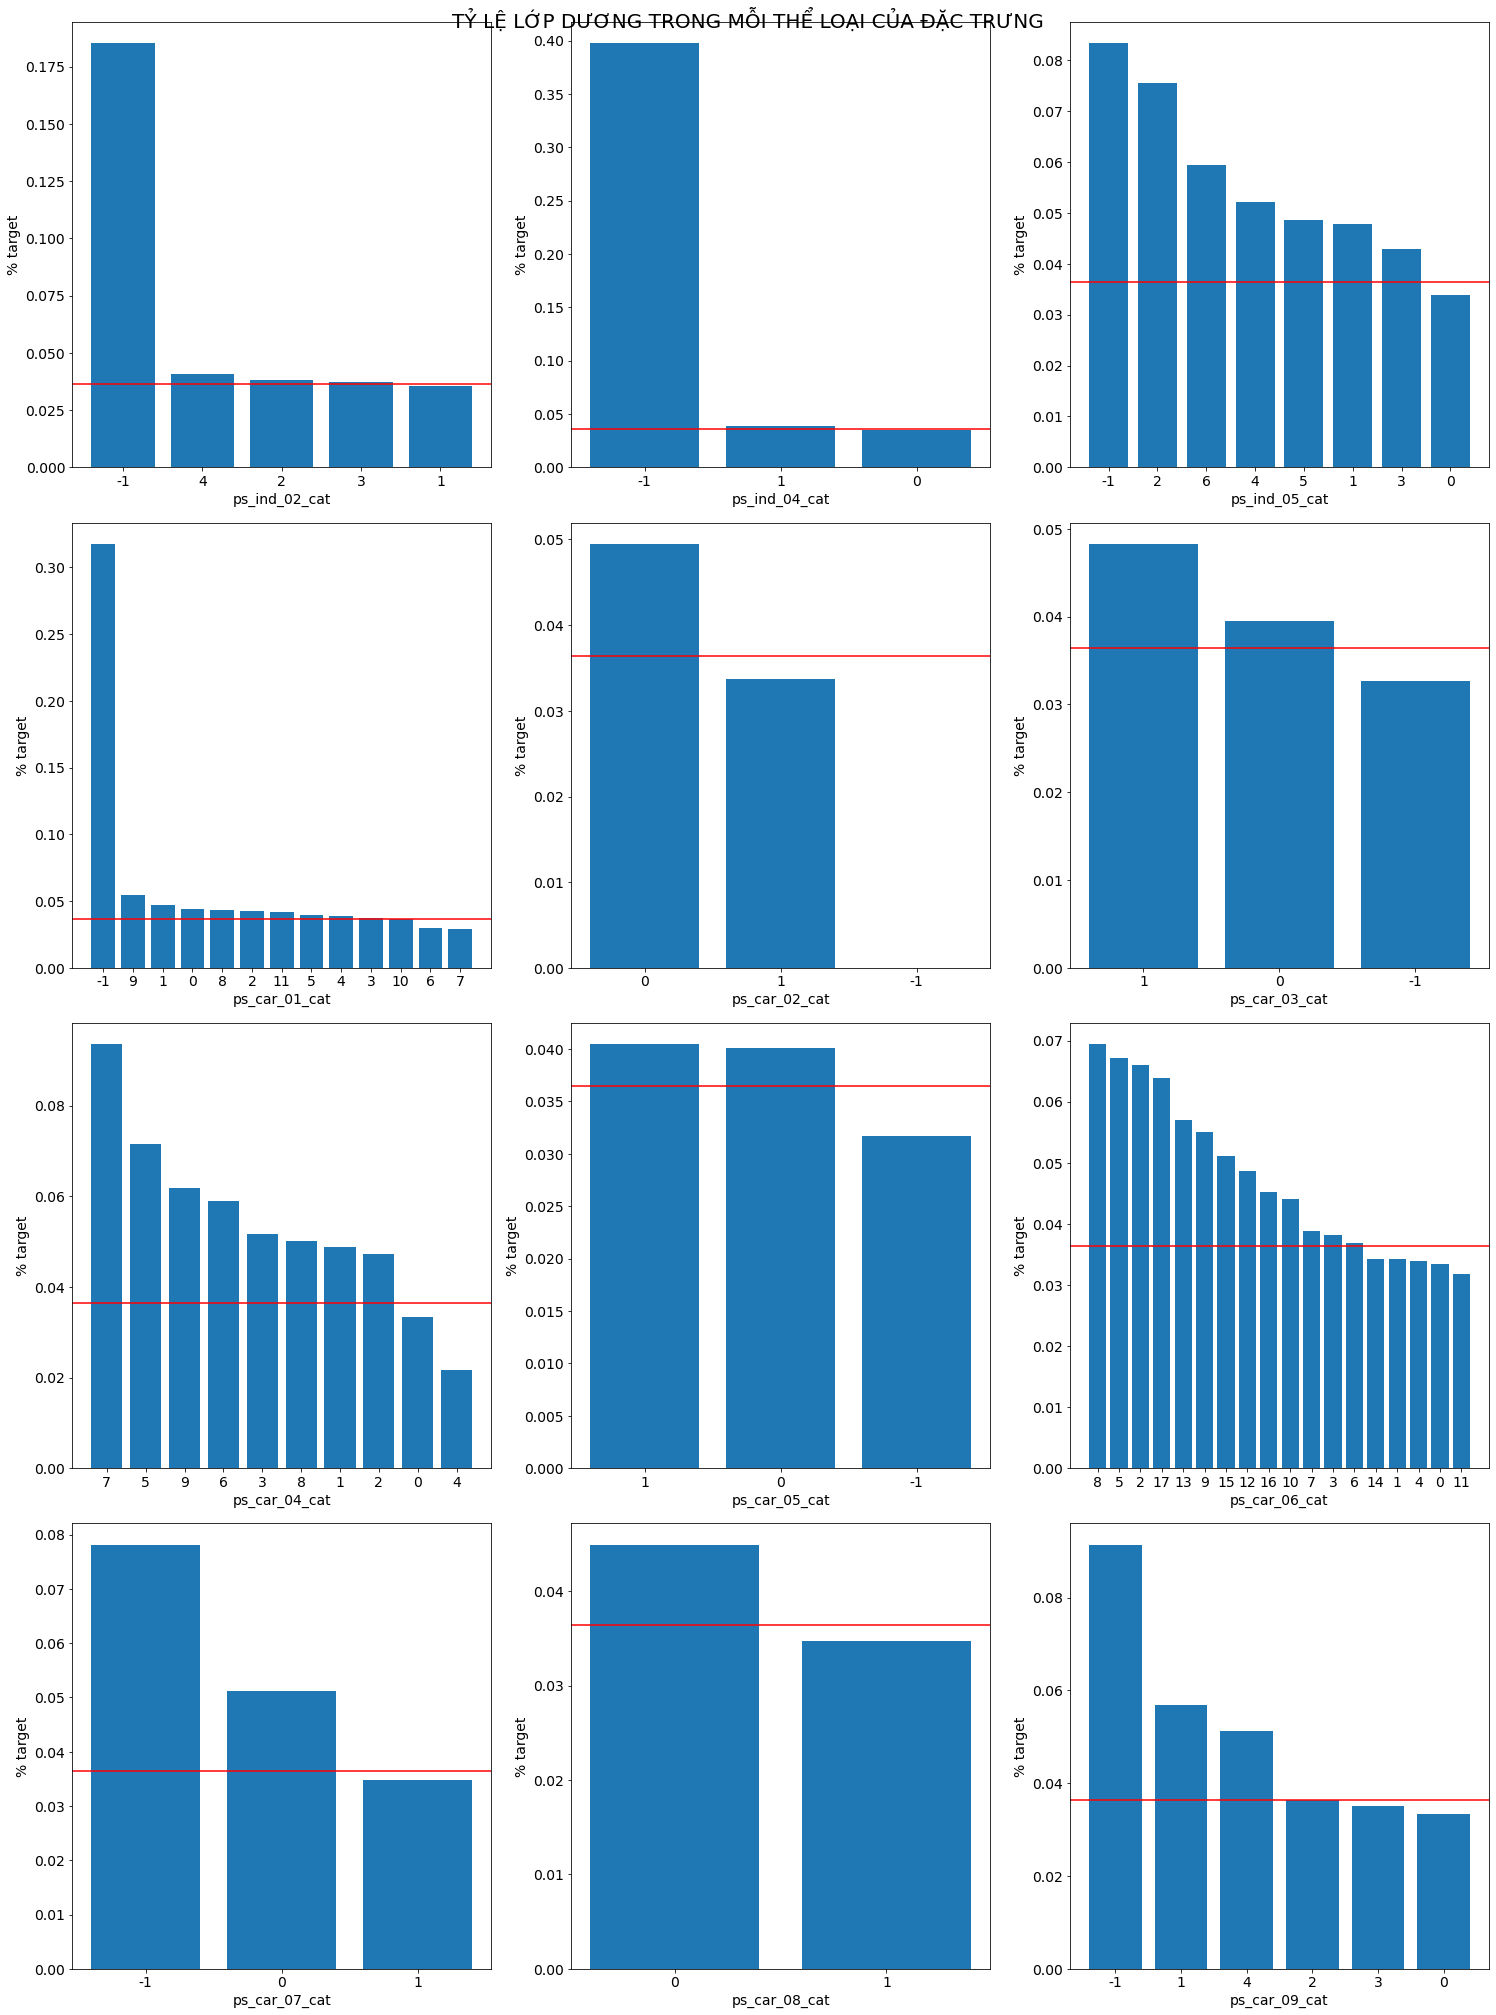

In [26]:
positive_ratio = train["target"].mean()

fig, axes = plt.subplots(4, 3, figsize=(21,28))
fig.suptitle("TỶ LỆ LỚP DƯƠNG TRONG MỖI THỂ LOẠI CỦA ĐẶC TRƯNG", y=1, fontsize=20)
axes = axes.flatten()
for f, ax in zip(cat_features[:-2], axes):
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    ax.bar(cat_perc[f].apply(str), cat_perc["target"])
    ax.set(xlabel=f, ylabel='% target')
    ax.axhline(y=positive_ratio, color="r")
plt.tight_layout()
plt.show();

#### Chuyển các đặc trưng categorical sang dạng `one hot`

Các trị null `-1` không được **impute** (điền giá trị mean hoặc mode) mà được xem như là một **giá trị thể loại** và được encode.

Suy đoán: Việc xem `null` như giá trị có thể là một ý hay.

In [27]:
for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])

#### Gộp các đặc trưng `ind` làm một (feature crossing)

Trên thực tế, các đặc trưng thường có mối quan hệ với nhau. Đôi khi những quan hệ này có ích nhưng một số mô hình học máy lại không nắm bắt được. Vì vậy việc thêm các mối quan hệ này như một đặc trưng mới có thể giúp mô hình tăng khả năng dự đoán. Thông thường các mối quan hệ được suy ra từ kiến thức miền (domain knowledge), hoặc được tìm ra bằng các kỹ thuật FE.

Đọc thêm: [link](https://machinelearningcoban.com/tabml_book/ch_data_processing/crossing.html)

Ở đây, ta gộp các đặc trưng `ind` thành một đặc trưng mới `new_ind`. Như vậy, các dòng có bộ giá trị đặc trưng từ `ind_01` đến `ind_18` giống nhau sẽ có giá trị `new_ind` cũng giống nhau. Đặc trưng mới này thể hiện được sự xảy ra đồng thời của các giá trị của các đặc trưng riêng lẻ.

In [28]:
ind_features = [c for c in feature_names if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'

In [29]:
train["new_ind"]

0          2_2_5_2_1_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_1_1_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_1_1_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_2_1_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
595207    3_1_10_1_1_0_0_0_1_0_0_0_0_0_13_1_0_0_
595208      5_1_3_1_1_0_0_0_1_0_0_0_0_0_6_1_0_0_
595209    1_1_10_1_1_1_0_0_0_0_0_0_0_0_12_1_0_0_
595210     5_2_3_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
595211      0_1_8_1_1_1_0_0_0_0_0_0_0_0_7_1_0_0_
Name: new_ind, Length: 595212, dtype: object

In [30]:
train["new_ind"].unique().shape[0]

93282

#### Đếm các đặc trưng `cat` kể cả `new_ind` (count/frequency encoding)

count/frequency encoding:
* Mã hóa một giá trị bằng số lần xuất hiện giá trị đó trong cột đặc trưng.
* Được sử dụng nhiều trong các cuộc thi Kaggle. Nhiều khi làm tăng khả năng dự đoán của mô hình.
* Bao gồm cả thông tin về tần suất xuất hiện của giá trị. Đôi khi thông tin này có ích cho việc dự đoán.
* Không như one hot, count encoding chỉ mã hóa đặc trưng bằng 1 cột -> lựa chọn tốt đối với các đặc trưng có số lượng giá trị lớn (the curse of dimensionality).

Đọc thêm: [link](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)

Thực hiện **count encoding** trên các đặc trưng `cat` bên cạnh **one hot encoding** (hậu tố `_count`).

Đặc trưng `new_ind` có số lượng giá trị phân biệt lớn nên cũng sẽ sử dụng mã hóa count.

Số lượng được count trên bộ dữ liệu gộp giữa **train** và **test** -> Để có số liệu thống kê tổng quát hơn.


In [31]:
cat_count_features = []
for c in cat_features+['new_ind']:
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

In [32]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

#### Tổng hợp các đặc trưng lại

Các đặc trưng bao gồm:
* Đặc trưng dạng số: 24
* Đặc trưng count encoding: 15
* đặc trưng one hot encoding: 184

=> Tổng cộng có 223 đặc trưng.

In [33]:
train_list = [train[num_features+cat_count_features].values, X_cat]
test_list = [test[num_features+cat_count_features].values, X_t_cat]

# Nén dữ liệu: Compressed Sparse Row format
X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

In [34]:
X.shape

(595212, 223)

In [35]:
X_test.shape

(892816, 223)

### Train LightGBM

*Phần này nhóm code lại và có chỉnh sửa đôi chút cho phù hợp. Ngoài ra nhóm còn có thêm phần tinh chỉnh siêu tham số.*

#### Giới thiệu LightGBM

Gradient boosting:
* **Ensemble** của một chuỗi các mô hình. Mô hình sau sẽ học cách cải thiện lỗi của các mô hình trước.
* **Gradient boosting**: sử dụng **gradient descent** để boost.

<img src="images/1.png" alt="1" width="1000"/>

Nguồn: [Link](https://youtu.be/iMal3Trpg2Y)



LightGBM (Lightweight Gradient Boosting Model):
* Một framework được phát triển bởi Microsoft.
* Một trong những thuật toán ensemble được ưa chuộng nhất.
* Base model dựa trên **Decision tree**, sử dụng **Gradient boosting**.

Điểm mạnh của LightGBM so với các model khác:
* Công việc tốn thời gian nhất các mô hình GBM là việc tìm kiếm **split points** (điểm phân chia quyết định). Sử dụng **histogram-based algorithms** (thực hiện rời rạc hóa đặc trưng liên tục thành các bin) giúp tăng tốc việc tìm kiếm và giảm bộ nhớ sử dụng.
* Đặc biệt, LightGBM sử dụng 2 thuật toán **GOSS** (Gradient Based One Side Sampling) và **EFB** (Exclusive Feature Bundling) giúp tăng tốc đáng kể quá trình này. ([link](https://programmersought.com/article/98713401245/))
* Phát triển cây dựa trên **leaf-wise** trong khi các mô hình khác sử dụng **level-wise** (**level-wise** phát triển leaf đồng thời trên cùng một độ sâu, dẫn tới nhiều node leaf có **split gain** thấp vẫn phải tách không cần thiết. **leaf-wise** chọn ra node leaf có **độ lỗi** lớn nhất để phát triển -> độ lỗi giảm mạnh hơn, tuy nhiên cây dễ phát triển quá sâu gây **overfit**, có thể giới hạn bằng `max_depth`).

<img src="images/2.jpeg" alt="2" width="1000"/>

#### Evaluation metric

*Hàm tính Gini score được implement rất nhiều trên Kaggle. Nhóm sử dụng hàm tính Gini của tác giả.*

In [36]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

#### Hyperparameter tuning

Huấn luyện sử dụng **k-fold cross validation** (5-fold):
* Xáo trộn và chia tập train thành 5 phần bằng nhau.
* Với mỗi phần ta lấy 4 phần còn lại làm tập train để dự đoán. Đồng thời dự đoán cho cả tập test.
* Ghép các dự đoán của các phần **validate** lại để có được kết quả đánh giá CV.
* Đối với tập test, ta lấy trung bình của 5 lần dự đoán làm kết quả cuối cùng.

<img src="images/3.jpeg" alt="3" width="1000"/>

In [ ]:
NFOLDS = 5

In [ ]:
ORIGINAL_PARAMS = {'num_leaves': 15,
                   'feature_fraction': 0.6,
                   'min_child_samples': 10,
                   'min_child_weight': 150}

Optuna:
* là 1 framework điều chỉnh siêu tham số tự động được sử dụng phổ biến trên Kaggle.
* Sử dụng tối ưu Bayesian (**Bayesian optimization**). Ý tưởng là dựa vào kết quả từ các lần đánh giá trước để đưa ra bộ tham số tiếp theo phù hợp. Nhờ vậy có thể nhanh chóng tìm ra bộ tham số tối ưu.
* Sử dụng Optuna: [link](https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c)


Vấn đề:
* Tập train lớn, việc tune tham số rất mất thời gian.
* Dùng một phần nhỏ data thì nhanh hơn, nhưng kết quả có thể sẽ không đúng với tập gốc.

Ý tưởng của nhóm:
* Chia tập train làm 2 phần: 30% dùng để thực hiện cross validate, 70% còn lại để đánh giá.
* Mỗi lần train của CV sẽ dự đoán trên phần test. Kết quả cuối cùng là trung bình cộng của 5 lần. Đánh giá trên kết quả này để chọn siêu tham số.
* Việc tuning sẽ nhanh hơn, đánh giá cũng tổng quát hơn.

<img src="images/4.png" alt="4" width="1000"/>

Trong solution của tác giả:
* Thực hiện huấn luyện cùng một bộ siêu tham số trên 16 random seed khác nhau (0-15) và lấy trung bình -> Tăng tính ổn định của kết quả.


Hướng cải tiến của nhóm:
* Qua thực nghiệm, ta thấy cùng một bộ siêu tham số có thể cho kết quả cao hơn ở seed này nhưng thấp hơn ở seed khác.
* Nếu ta tìm bộ siêu tham số riêng cho từng seed thì sao?
* Chọn ngẫu nhiên 5 seed (0, 2, 5, 7, 12). Tìm bộ tham số tối ưu cho mỗi seed. Cuối cùng lấy trung bình toàn bộ.

In [ ]:
from sklearn.model_selection import train_test_split

tune_X, tune_X_test, tune_y, tune_y_test = train_test_split(X, train_label, test_size=0.7, random_state=218, stratify=train_label)

In [ ]:
! pip install optuna

In [ ]:
from optuna.integration import LightGBMPruningCallback
import optuna

In [ ]:
def objective(trial, X, y, X_test, y_test):
    param_grid = {
        'objective': 'binary',
        'verbosity': 0,
        "num_leaves": trial.suggest_int("num_leaves", 5, 55, step=5),
        "min_child_samples": trial.suggest_int("min_child_samples", 0, 150, step=10),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 200.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
        "seed": 12, # Thay thế seed
    }

    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

    cv_train = np.zeros(len(y))
    cv_pred = np.zeros(len(y_test))

    kf = kfold.split(X, y)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], y[train_fold], y[validate]

        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)

        bst = lgbm.train(param_grid, dtrain, num_boost_round=10000, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                         early_stopping_rounds=100,
                         callbacks=[LightGBMPruningCallback(trial, "gini")])

        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)

        score = Gini(label_validate, cv_train[validate])
        print(score)
        fold_scores.append(score)

    cv_pred /= NFOLDS

    cv_score = Gini(y, cv_train)
    print("cv score: {cv_score}")
    print(fold_scores)
    test_score = Gini(y_test, cv_pred)
    print("test score: {test_score}")
    print(best_trees, np.mean(best_trees))

    return test_score

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, tune_X, tune_y.values, tune_X_test, tune_y_test)
study.optimize(func, n_trials=10)

In [ ]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

#### Train

**Private score** | **Public score**

Score của tác giả (thời gian train trên Colab là hơn 1 tiếng)

![5](images/5.png)

Score của nhóm (train 5 seed với thời gian ít hơn 30 phút)

![6](images/6.png)

*Bộ tham số nhóm tìm được.*

In [70]:
FIXED_PARAMS = {'objective': 'binary', 'verbosity': 0}

SEARCH_PARAMS =     [{'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 100,
                    'min_child_weight': 101.94095152382667,
                    'seed': 0},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 60,
                    'min_child_weight': 124.66803210058042,
                    'seed': 2},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 150,
                    'min_child_weight': 148.13731979766956,
                    'seed': 5},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 30,
                    'min_child_weight': 157.2373873709297,
                    'seed': 7},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 10,
                    'min_child_weight': 125.16184758062035,
                    'seed': 12}]

In [71]:
NFOLDS = 5

In [72]:
def cv_gbm(params):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)
    kf = kfold.split(X, train_label)

    #best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        print("Fold {}/{}".format(i+1, NFOLDS))

        X_train, X_validate, label_train, label_validate = \
            X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]

        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
        
        bst = lgbm.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                        early_stopping_rounds=100)

        #best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate, num_iteration=bst.best_iteration)

        score = Gini(label_validate, cv_train[validate])
        print(score)
        fold_scores.append(score)

    cv_pred /= NFOLDS

    print(fold_scores)

    return cv_train, cv_pred

In [73]:
num_seed = len(SEARCH_PARAMS)
x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s, s_param in enumerate(SEARCH_PARAMS):
    print("param", s)
    params = {**s_param, **FIXED_PARAMS}

    cv_train, cv_pred = cv_gbm(params)
    final_cv_train += cv_train
    final_cv_pred += cv_pred

    cv_score = Gini(train_label, cv_train)
    print("cv score:", cv_score)
    print("current score:", Gini(train_label, final_cv_train / (s + 1.)))

    x_score.append(cv_score)

print("cv scores:", x_score)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / num_seed}).to_csv('./lgbm_pred.csv', index=False)
#pd.DataFrame({'id': train_id, 'target': final_cv_train / num_seed}).to_csv('./lgbm_cv.csv', index=False)

param 0
Fold 1/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.2917
[200]	valid_0's gini: 0.296619
[300]	valid_0's gini: 0.298217
Early stopping, best iteration is:
[285]	valid_0's gini: 0.298823
0.2988230017522822
Fold 2/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.273403
[200]	valid_0's gini: 0.276096
[300]	valid_0's gini: 0.276963
[400]	valid_0's gini: 0.276298
Early stopping, best iteration is:
[317]	valid_0's gini: 0.277578
0.2775776932068178
Fold 3/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.271352
[200]	valid_0's gini: 0.278896
[300]	valid_0's gini: 0.280592
[400]	valid_0's gini: 0.280214
Early stopping, best iteration is:
[364]	valid_0's gini: 0.281552
0.28155193979431314
Fold 4/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.284072
[200]	valid_0's gini: 0.286093
[300]	valid_0's gini: 0.284931
Early stopping, 

### Feature engineer + Khám phá dữ liệu (Neural networks)

Bao gồm:
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Thêm đặc trưng: Nhân và chia của 2 đặc trưng (feature interacting using Equations)
* Đếm giá trị các đặc trưng `cat`
* Thêm các đặc trưng Groupby (feature interacting using Groupby)
* Đặc trưng huấn luyện bằng XGBoost

*Phần này hầu hết code của tác giả, nhóm chỉ code theo và chỉnh sửa lại một vài chỗ theo ý hiểu của nhóm và để dễ hiểu hơn.*
*Riêng những phần nội dung tìm hiểu là nhóm tự tìm hiểu và thực hiện để trình bày.*

In [74]:
# Đọc dữ liệu và xóa các cột id, target(tập train)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

train_id = train['id']
train_label = train['target']

del train['id']
del train['target']

test_id = test['id']
del test['id']

(595212, 59)
(892816, 58)


#### Đếm số lượng giá trị thiếu từng dòng


Trong các đặc trưng có giá trị thiếu, tỉ lệ lớp dương trong giá trị thiếu thường chênh lệch lớn. 

=> Vì vậy, số lượng giá trị thiếu có thể là một đặc trưng quan trọng.


In [75]:
#thêm cột missing là giá trị thiếu trên mỗi dòng
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)

In [76]:
display(train['missing'])

0         1.0
1         2.0
2         3.0
3         0.0
4         2.0
         ... 
595207    1.0
595208    3.0
595209    2.0
595210    2.0
595211    3.0
Name: missing, Length: 595212, dtype: float64

#### Nhân và chia đặc trưng (feature interacting using Equations)


Nhiều mô hình học máy có cách làm riêng để kết hợp các đặc trưng với nhau (như NN sẽ là tổng có trọng số các đặc trưng). Tuy nhiên, kinh nghiệm cho thấy ta vẫn nên kết hợp các đặc trưng bằng tay thay vì dựa dẫm quá nhiều vào mô hình. Nếu cách kết hợp được chọn lựa tốt thì có thể sẽ giúp ta vươn xa trong các cuộc thi Kaggle.

Có rất nhiều cách kết hợp đặc trưng. Ngoài **domain knowledge**, ta có thể thử tất cả các cách kết hợp có thể. Để không tốn nhiều thời gian ta nên lựa chọn theo 3 tiêu chí sau:
* **effect sparsity**: càng ít feature được kết hợp với nhau, càng tăng tính hiệu quả của feature mới kết hơp. Thường chỉ cần từ 2 tới 3.
* **heredity**: feature mới kết hợp từ các feature riêng lẻ được cho là có tính hiệu quả chỉ khi ít nhất một feature thành phần có tính hiệu quả.
* **priority**: hầu hết các trường hợp, sẽ tốt hơn khi kết hợp các feature gốc chưa qua biến đổi (scale, log-transform,...).

Đọc thêm: [link](https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering) (mục `4. Combine Features`)

Ở đây ta sử dụng 2 cách kết hợp đặc trưng là tích và thương của 2 đặc trưng:
* Thực hiện trên một số đặc trưng quan trọng được lựa chọn bằng **feature selection**
* Số lượng đặc trưng: `6C2 * 2 = 30` (6C2 tổ hợp, mỗi tổ hợp tạo ra 2 đặc trưng nhân/chia)
* Prefix: `inter_`



In [79]:
#Hàm thực hiện tạo ra 2 đặc trưng nhân và chia. 
#Sau đó thêm chúng vào cả tập train và test với tiền tố 'inter'
def interaction_features(train, test, fea1, fea2, prefix):
    train['inter_{}*'.format(prefix)] = train[fea1] * train[fea2]
    train['inter_{}/'.format(prefix)] = train[fea1] / train[fea2]

    test['inter_{}*'.format(prefix)] = test[fea1] * test[fea2]
    test['inter_{}/'.format(prefix)] = test[fea1] / test[fea2]

    return train, test

In [80]:
#Những đặc trưng dưới đây là những đặc trưng quan trọng, đóng góp nhiều cho mô hình nên được tác giả chọn ra \
#để tạo ra những đặc trưng nhân/chia
features= ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01']

In [81]:
'''
combinations(list, n): Hàm tạo tổ hợp bậc n từ các phần tử trong list
combinations(['A', 'B','C'],2)  retrun AB AC BC

enumerate(list): Hàm tạo một dãy liệt kê. có đánh số thứ tự cho mỗi phần tử
'''
for e, (x, y) in enumerate(combinations(features, 2)):
  train, test = interaction_features(train, test, x, y, e)

In [82]:
inter_fea = [fea for fea in list(train) if 'inter' in fea]
train[inter_fea]

,inter_0*,inter_0/,inter_1*,inter_1/,inter_2*,inter_2/,inter_3*,inter_3/,inter_4*,inter_4/,inter_5*,inter_5/,inter_6*,inter_6/,inter_7*,inter_7/,inter_8*,inter_8/,inter_9*,inter_9/,inter_10*,inter_10/,inter_11*,inter_11/,inter_12*,inter_12/,inter_13*,inter_13/,inter_14*,inter_14/
0,4.418395,0.176736,0.634544,1.230630,9.720468,0.080334,0.618575,1.262398,1.767358,0.441839,3.590352,6.963106,55,0.454545,3.5,7.142857,10,2.500000,7.898774,0.065279,0.502649,1.025815,1.436141,0.359035,7.7,15.714286,22,5.500000,1.4,0.350000
1,4.331716,0.088402,0.474062,0.807773,1.856450,0.206272,0.495053,0.773521,0.618817,0.618817,5.362544,9.137455,21,2.333333,5.6,8.750000,7,7.000000,2.298233,0.255359,0.612862,0.957597,0.766078,0.766078,2.4,3.750000,3,3.000000,0.8,0.800000
2,5.774271,0.071287,-0.641586,-0.641586,7.699029,0.053465,0.000000,inf,3.207929,0.128317,-9.000000,-9.000000,108,0.750000,0.0,inf,45,1.800000,-12.000000,-0.083333,-0.000000,-inf,-5.000000,-0.200000,0.0,inf,60,2.400000,0.0,0.000000
3,1.085898,0.271474,0.315425,0.934592,4.343590,0.067869,0.488654,0.603276,0.000000,inf,1.161895,3.442652,16,0.250000,1.8,2.222222,0,inf,4.647580,0.072618,0.522853,0.645497,0.000000,inf,7.2,8.888889,0,inf,0.0,inf
4,0.000000,inf,0.475728,0.673001,5.092484,0.062870,0.396082,0.808331,0.000000,inf,0.000000,0.000000,0,0.000000,0.0,0.000000,0,NaN,7.566827,0.093418,0.588531,1.201084,0.000000,inf,6.3,12.857143,0,inf,0.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,6.846306,0.068463,0.474326,0.988179,8.900197,0.052664,0.342315,1.369261,2.053892,0.228210,6.928203,14.433757,130,0.769231,5.0,20.000000,30,3.333333,9.006664,0.053294,0.346410,1.385641,2.078461,0.230940,6.5,26.000000,39,4.333333,1.5,0.166667
595208,2.916434,0.324048,1.343531,0.703419,5.832867,0.162024,0.874930,1.080161,4.860723,0.194429,4.146082,2.170724,18,0.500000,2.7,3.333333,15,0.600000,8.292165,0.230338,1.243825,1.535586,6.910137,0.276405,5.4,6.666667,30,1.200000,4.5,0.180000
595209,5.963733,0.059637,0.393053,0.904869,7.156480,0.049698,0.536736,0.662637,0.596373,0.596373,6.590713,15.172865,120,0.833333,9.0,11.111111,10,10.000000,7.908856,0.054923,0.593164,0.732301,0.659071,0.659071,10.8,13.333333,12,12.000000,0.9,0.900000
595210,2.293302,0.254811,0.533737,1.094845,9.173209,0.063703,0.687991,0.849371,3.822171,0.152887,2.094636,4.296689,36,0.250000,2.7,3.333333,15,0.600000,8.378544,0.058184,0.628391,0.775791,3.491060,0.139642,10.8,13.333333,60,2.400000,4.5,0.180000


In [83]:
# Tách các tập num,cat 
feature_names = list(train)
cat_fea = [fea for fea in feature_names if 'cat' in fea]
num_fea = [fea for fea in feature_names if ('cat' not in fea) and ('calc' not in fea)]

##### Thí nghiệm Feature Importance

Nhóm thử nghiệm dùng **LightGBM** để train trên tập 23 đặc trưng dạng số của dữ liệu gốc và xếp hạng độ quan trọng của chúng.

=> Các đặc trưng mà tác giả chọn ở trên đều là những đặc trưng quan trọng.

In [86]:
num_feaimp = ['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

In [87]:
X_feaimp = train[num_feaimp]

In [95]:
params_feaimp = {'objective': 'binary',
          'verbosity': 0,
          'num_boost_round': 1000,
          'num_leaves': 15,
          'seed': 0
          }

In [97]:
gbm = lgbm.LGBMClassifier(**params_feaimp)
gbm.fit(X_feaimp, train_label.values)

LGBMClassifier(num_boost_round=1000, num_leaves=15, objective='binary', seed=0,
               verbosity=0)

In [100]:
fea_imp = pd.DataFrame({'cols':num_feaimp, 'fea_imp':gbm.feature_importances_})
fea_imp.loc[fea_imp.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
20,ps_car_13,2218
17,ps_reg_03,2185
21,ps_car_14,1867
1,ps_ind_03,1133
11,ps_ind_15,1072
16,ps_reg_02,1007
19,ps_car_12,840
0,ps_ind_01,803
15,ps_reg_01,711
22,ps_car_15,689


#### Đếm các đặc trưng `cat`



Gộp các đặc trưng của mỗi nhóm `ind`, `reg` và `car` với nhau thành 3 đặc trưng mới: `new_ind`, `new_reg`, `new_car`

Đếm số lượng giá trị của các đặc trưng **categorical** (bao gồm 3 đặc trưng mới)

In [101]:
def Series_string(train, test, category_list):
    '''
    produce series as a string like new_ind as the following
   id        new_ind_count                    new_ind
595207            117       3_1_10_0_0_0_0_0_1_0_0_0_0_0_13_1_0_0
595208            153       5_1_3_0_0_0_0_0_1_0_0_0_0_0_6_1_0_0

    return train and test with new colunes of new_categories 
    '''
    for category in category_list:

        feature_names = list(train.columns)

        features = [c for c in feature_names if category in c]
        name= 'new_'+ category


        count = 0
        for c in features:
            if count == 0:
                train[name] = train[c].astype(str)
                count += 1
            else:
                train[name] += '_' + train[c].astype(str)

        count = 0
        for c in features:
            if count == 0:
                test[name] = test[c].astype(str)
                count += 1
            else:
                test[name] += '_' + test[c].astype(str)

    return train, test

In [102]:
category_list = ['ind', 'reg', 'car']
train, test = Series_string(train,test,category_list)

In [103]:
display(train[['new_ind','new_reg','new_car']].head(5))

,new_ind,new_reg,new_car
0,2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0,0.7_0.2_0.7180703307999999,10_1_-1_0_1_4_1_0_0_1_12_2_0.4_0.8836789178_0....
1,1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1,0.8_0.4_0.7660776723,11_1_-1_0_-1_11_1_1_2_1_19_3_0.316227766_0.618...
2,5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0,0.0_0.0_-1.0,7_1_-1_0_-1_14_1_1_2_1_60_1_0.316227766_0.6415...
3,0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0,0.9_0.2_0.5809475019,7_1_0_0_1_11_1_1_3_1_104_1_0.3741657387_0.5429...
4,0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0,0.7_0.6_0.840758586,11_1_-1_0_-1_14_1_1_2_1_82_3_0.3160696126_0.56...


In [104]:
cat_count_features = []
features = cat_fea + ['new_ind', 'new_reg', 'new_car']

for fea in features:
  d = pd.concat([train[fea],test[fea]]).value_counts().to_dict()
  train['%s_count'%fea] = train[fea].apply(lambda x:d.get(x,0))
  test['%s_count'%fea] = test[fea].apply(lambda x:d.get(x,0))
  cat_count_features.append('%s_count'%fea)

In [105]:
display(train[cat_count_features].head(5))

,ps_ind_02_cat_count,ps_ind_04_cat_count,ps_ind_05_cat_count,ps_car_01_cat_count,ps_car_02_cat_count,ps_car_03_cat_count,ps_car_04_cat_count,ps_car_05_cat_count,ps_car_06_cat_count,ps_car_07_cat_count,ps_car_08_cat_count,ps_car_09_cat_count,ps_car_10_cat_count,ps_car_11_cat_count,new_ind_count,new_reg_count,new_car_count
0,309747,620936,1319412,124587,1234979,1028142,1241334,431560,77845,1383070,249663,486510,1475460,18326,6,24,1
1,1079327,866864,1319412,518725,1234979,1028142,1241334,666910,329890,1383070,1238365,883326,1475460,12535,36,38,11
2,28259,620936,1319412,449617,1234979,1028142,1241334,666910,147714,1383070,1238365,883326,1475460,19943,24,13477,40
3,1079327,866864,1319412,449617,1234979,183044,1241334,431560,329890,1383070,1238365,36798,1475460,212989,2784,222,1
4,309747,620936,1319412,518725,1234979,1028142,1241334,666910,147714,1383070,1238365,883326,1475460,26161,258,34,13


#### Các đặc trưng Groupby (feature interacting using Groupby)


Đôi khi đặc trưng kết hợp dựa trên việc **groupby** feature này theo feature kia có thể tăng hiệu quả mô hình. Giả sử ta có 2 feature là `lương` nhân viên và `phòng ban` của họ. Bản thân `lương` đã là một đặc trưng tốt. Nhưng nếu ta so sánh `lương` người này với người kia trong chính `phòng ban` của họ, ta có thể hiểu được tại sao người này không hài lòng với công việc trong khi người kia thì hài lòng, cho dù `lương` của người này cao hơn nhiều so với người của `phòng ban` khác.

Đọc thêm: link ở trên.

Chọn 2 đặc trưng (`target_feature` và `group_feature`), gom nhóm `target_feature` theo `group_feature`.

Thực hiện các thống kê (count, min, max, median, mean, std) trên từng group.

Số lượng đặc trưng:
* 5 target_features, 6 group_features: 36 cách chọn
* 6 thống kê count, min, max, median, mean, std
* tổng số đặc trưng: `36 * 6 = 216`

Thống kê được thực hiện trên tập dữ diệu gộp của `train` và `test` -> tổng quát hơn.

In [106]:

def Statistic_features(train, test, target_features, group_features):
    train_list_=[]
    test_list_=[]
    for t in target_features:
        for g in group_features:
            if t != g:
                s_train, s_test = proj_num_on_cat(train, test, target_column=t, group_column=g)
                train_list_.append(s_train)
                test_list_.append(s_test)
    return np.hstack(train_list_), np.hstack(test_list_)

In [ ]:
#feature aggregation
target_features = ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01']
group_features = ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01', 'ps_ind_05_cat']

train_statis, test_statis =  Statistic_features(train, test, target_features, group_features)

In [108]:
train_statis_df = pd.DataFrame(train_statis)
test_statis_df = pd.DataFrame(test_statis)


#### Đặc trưng huấn luyện bằng XGBoost

Ước tính phần này mất đến 2 ngày (48 tiếng) để train. Hiện tại nhóm không có đủ phần cứng để làm nên nhóm sẽ tạm thời bỏ qua.

#### Nối các đặc trưng dạng số để chuẩn bị cho NN model

Các đặc trưng dạng số bao gồm:
* 54 đặc trưng dạng số trong tập tập train/test(23 num_fea ban đầu, 1 missing, 30 inter_)
* 17 đặc trưng `cat_count_features`
* 216 đặc trưng statis

=> Tổng có 287 đặc trưng

Toàn bộ các đặc trưng này được đưa qua **Standard Scaler**.

In [109]:
print("num_fea: ", len(num_fea))
print("cat_count_features: ", len(cat_count_features))
print("train_statis: ", train_statis.shape[1])

num_fea:  54
cat_count_features:  17
train_statis:  216


In [110]:
train_num = train[num_fea].replace([np.inf, -np.inf, np.nan], 0)
test_num = test[num_fea].replace([np.inf, -np.inf, np.nan], 0)

In [111]:
train_df= pd.concat([train_num, train[cat_count_features], train_statis_df], axis =1)
test_df= pd.concat([test_num, test[cat_count_features], test_statis_df], axis =1)

In [112]:
del train_num
del test_num
del train_statis_df
del test_statis_df

In [113]:
X = train_df.to_numpy()

In [114]:
X_test = test_df.to_numpy()

In [115]:
X_test.shape

(892816, 287)

In [116]:
all_data = np.vstack((X,X_test))

In [117]:
scaler = StandardScaler()
scaler.fit(all_data)
X = scaler.transform(X)
X_test = scaler.transform(X_test)


In [118]:
del all_data

#### Tạo các đặc trưng dạng Categorical để chuẩn bị cho Embedding layer ####

Các đặc trưng thể loại được gắn kèm với đặc trưng dạng số.

Như vậy, dữ liệu feed cho mô hình bao gồm:
* 14 đặc trưng thể loại để `embedding`.
* 287 đặc trưng dạng số.

In [ ]:
#preparing for training cat 
train_cat = train[cat_fea]
test_cat = test[cat_fea]

# convert pd to np.array
X_cat = train_cat.values
tem = test_cat.values

# storing the dimension for embedding layer as an input value
max_cat_values = []

for c in cat_fea:
    
    #nomalize the label
    #Mục đích chỉ để tìm số chiều(số phần tử khác nhau của mỗi cột) để truyền vào tham số input_dim của embedding layer
    le = LabelEncoder()
    x = le.fit_transform(pd.concat([train_cat, test_cat])[c])
    train_cat.loc[:,c] = le.transform(train_cat[c])
    test_cat.loc[:,c] = le.transform(test_cat[c])
    max_cat_values.append(np.max(x))

# Build the final testing data
X_TEST_CAT = []
for i in range(tem.shape[1]):
    X_TEST_CAT.append(tem[:, i].reshape(-1, 1))
X_TEST_CAT.append(X_test)

del train_cat
del test_cat

In [ ]:
print('cat_fea:', cat_fea)
print('\nmax_cat_values: ',max_cat_values)

cat_fea: ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']

max_cat_values:  [4, 2, 7, 12, 2, 2, 9, 2, 17, 2, 1, 5, 2, 103]


### Train Neural Networks

*Phần này nhóm cũng code lại theo tác giả và có tinh chỉnh một số chỗ cho phù hợp, chưa có cải tiến gì đáng kể.*

#### Model structure

<img src="images/9.png" alt="9" width="1000"/>

#### Input


* Các đặc trưng dạng số: **287** đặc trưng bao gồm các đặc trưng `num` có sẵn, `missing`, `inter_` và các đặc trưng `groupby`.
* Đặc trưng dạng Categorical: Với những dạng đặc trưng dạng `cat`, ta đưa vào `Embedding layer` để chuyển các đặc trưng này về dạng vector có chiều quy định nhằm đồng nhất số chiều của các lớp. 
* Mỗi `cat` feature được đưa vào một `Embedding layer` riêng.

#### Layers

* **Embedding**: Đưa các vector có số chiều lớn, thường là dữ liệu khả tách, về một vector có số chiều nhỏ hơn, thường ở dạng dày đặc. Làm cho các giá trị có ý nghĩa tương tự nhau nằm gần nhau trong không gian embedding. Các tham số của lớp embedding: input_dim = num_c + 1, output_dim, input_length. Các đặc trưng dạng Categorical được đưa vào lớp 

* **Merge**: Merge hai đặc trưng `Cat` và `Num` lại với nhau theo phương pháp `Concatenate`.
* **Dense**: layer này sử dụng như một layer neural network bình thường.
* **Output**: Là một `dense` layer với 1 node(nhận giá trị nhị phân)

In [ ]:
## model
def nn_model():
    inputs = []
    flatten_layers = []
    for e, c in enumerate(cat_fea):
        input_c = Input(shape=(1, ), dtype='int32')
        num_c = max_cat_values[e]
        
        # **input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.**
        embed_c = Embedding(num_c+1,6,input_length=1)(input_c)
        embed_c = Dropout(0.25)(embed_c)
        flatten_c = Flatten()(embed_c)
        inputs.append(input_c)
        flatten_layers.append(flatten_c)
        
    input_num = Input(shape=(X.shape[1],), dtype='float32')
    inputs.append(input_num)
    
    #merge X and embedding layer
    flatten_layers.append(input_num)
    #flatten = merge(flatten_layers, mode='concat') 
    flatten = Concatenate()(flatten_layers)
    
    fc1 = Dense(512, kernel_initializer='he_normal')(flatten)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.75)(fc1)
    
    fc1 = Dense(64, kernel_initializer='he_normal')(fc1)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.5)(fc1)

    outputs = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(fc1)

    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return (model)

#### Train

**Phương pháp đánh giá mô hình: K-fold cross validation**
* Xáo trộn tập dữ liệu và chia ra thành k tập (fold).
* Thực hiện k lần, mỗi lần sẽ sử dụng k - 1 fold để train và đánh giá trên fold còn lại. Như vậy k fold đều có thể thành tập test.
* Có k kết quả, sau khi kết thúc sẽ lấy kết quả dựa vào việc tổng hợp các kết quả.
* Kết quả thực nghiệm cho thấy k=5 hoặc k=10 cho ra kết quả tốt nhất.

Private score của tác giả là `0.290X`.

**Private score** | **Public score**

Score của nhóm (không XGBoost) thấp hơn 1 chút.

![7](images/7.png)

In [ ]:
"""

X: training data 
train_label: nhãn

"""
def get_rank(x):
  return pd.Series(x).rank(pct=True).values

def cv_nn(X, train_label): 
  cv_train = np.zeros(len(train_label))
  cv_pred = np.zeros(len(test_id))

  #validation fold
  NFOLDS = 5
  kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

  cv_only = True
  save_cv = True

  fold_scores = []

  for (train_index, valid_index) in kfold.split(X, train_label):
      
      #gán dữ liệu từ training data và nhãn cho validation data; 
      x_train = X[train_index]
      y_train = train_label[train_index]
      x_valid= X[valid_index]
      y_valid = train_label[valid_index]
      
      # gán X_cat cho validation data; 
      x_train_cat = X_cat[train_index]
      x_valid_cat = X_cat[valid_index]

      
      x_train_cat_list, x_valid_cat_list = [], []
      for i in range(x_train_cat.shape[1]):
          x_train_cat_list.append(x_train_cat[:, i].reshape(-1, 1))
          x_valid_cat_list.append(x_valid_cat[:, i].reshape(-1, 1))

      x_train_cat_list.append(x_train)
      x_valid_cat_list.append(x_valid)
      
      #load model
      model = nn_model()
      
      #fit model. Note: thay đổi epochs để dự đoán chính xác hơn
      model.fit(x_train_cat_list, y_train, epochs=20, batch_size=512, verbose=2, validation_data=[x_valid_cat_list, y_valid])
      
      #prediction with validation data
      cv_train[valid_index] += get_rank(model.predict(x=x_valid_cat_list, batch_size=512, verbose=0)[:, 0])
      #prediction with testing data
      cv_pred += get_rank(model.predict(x=X_TEST_CAT, batch_size=512, verbose=0)[:, 0])

      score = Gini(train_label[valid_index], cv_train[valid_index])
      print('local fold Gini: ', score)
      fold_scores.append(score)
      
  cv_pred /= NFOLDS
  print(fold_scores)
  
  return cv_train, cv_pred


In [ ]:
num_seeds = 5
begintime = time()
x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(num_seeds):
  np.random.seed(s)

  cv_train, cv_pred = cv_nn(X, train_label)
  final_cv_train += cv_train
  final_cv_pred += cv_pred

  cv_score = Gini(train_label, cv_train)
  print("cv scores:", cv_score)

  x_score.append(cv_score)
  print("seed {0}: Gini {1}".format(s,Gini(train_label,final_cv_train / (1. * (s + 1)))))

print("cv scores:", x_score)
print("Total training time: ",str(datetime.timedelta(seconds=time() - begintime)))

pd.DataFrame({'id': test_id, 'target': get_rank(final_cv_pred * 1./ (5 * num_seeds))}).to_csv('keras_pred.csv', index=False)
#pd.DataFrame({'id': train_id, 'target': get_rank(final_cv_train * 1. / num_seeds)}).to_csv('keras_cv.csv', index=False)



Epoch 1/20
931/931 - 20s - loss: 0.2670 - val_loss: 0.1650 - 20s/epoch - 22ms/step
Epoch 2/20
931/931 - 18s - loss: 0.1687 - val_loss: 0.1590 - 18s/epoch - 19ms/step
Epoch 3/20
931/931 - 18s - loss: 0.1641 - val_loss: 0.1561 - 18s/epoch - 19ms/step
Epoch 4/20
931/931 - 18s - loss: 0.1601 - val_loss: 0.1538 - 18s/epoch - 19ms/step
Epoch 5/20
931/931 - 18s - loss: 0.1579 - val_loss: 0.1531 - 18s/epoch - 19ms/step
Epoch 6/20
931/931 - 17s - loss: 0.1558 - val_loss: 0.1521 - 17s/epoch - 19ms/step
Epoch 7/20
931/931 - 18s - loss: 0.1545 - val_loss: 0.1520 - 18s/epoch - 19ms/step
Epoch 8/20
931/931 - 18s - loss: 0.1539 - val_loss: 0.1520 - 18s/epoch - 19ms/step
Epoch 9/20
931/931 - 17s - loss: 0.1534 - val_loss: 0.1517 - 17s/epoch - 19ms/step
Epoch 10/20
931/931 - 17s - loss: 0.1532 - val_loss: 0.1516 - 17s/epoch - 19ms/step
Epoch 11/20
931/931 - 17s - loss: 0.1529 - val_loss: 0.1517 - 17s/epoch - 19ms/step
Epoch 12/20
931/931 - 17s - loss: 0.1527 - val_loss: 0.1516 - 17s/epoch - 19ms/step
E

### Ensemble kết quả của LightGBM và Neural Networks

Ở phần này, kết quả của 2 mô hình **LightGBM** và **Neural Netwworks** được tổng hợp bằng cách lấy trung bình có trọng số. Nhóm thí nghiệm và thấy tỉ lệ rơi vào khoảng `0.7LightGBM+0.3NN` cho kết quả cao nhất.

**Private score** | **Public score**

![8](images/8.png)

Kết quả ensemble của tác giả trên Private Leaderboard là `0.2938`.

Kết quả của nhóm tuy thấp hơn một chút nhưng vẫn đứng top 2 (không tính tác giả).

In [ ]:
keras5_test = pd.read_csv("keras_pred.csv")
lgbm3_test = pd.read_csv("lgbm_pred.csv")

def get_rank(x):
    return pd.Series(x).rank(pct=True).values

pd.DataFrame({'id': keras5_test['id'], 'target':
    get_rank(keras5_test['target']) * 0.3 + get_rank(lgbm3_test['target']) * 0.7}).to_csv(
    "final_result_final.csv", index = False)

## Nhìn lại quá trình làm đồ án

**Nguyễn Trần Trung:**
* Khó khăn:
    * Tác giả chỉ cung cấp code, không giải thích rõ ràng vì sao lại làm như thế, phải tự nghiên cứu tìm hiểu hầu hết.
    * Thời gian hạn chế vì có nhiều đồ án môn khác.
* Học được:
    * Quy trình Khoa học dữ liệu hoàn chỉnh cho một bài toán.
    * Các kỹ thuật thường được sử dụng trong solution đạt giải (các kỹ thuật Feature Engineering, LightGBM,...).

**Phạm Viết Xuân:**
* Khó khăn:
    * Phần train XGBoost ước tính mất đến 2 ngày để train, phần cứng không đủ khả năng train.
    * Ban đầu khá chật vật với phần Neural Networks vì dung lượng RAM của Colab không đủ.
    * Thời gian hạn chế vì có nhiều đồ án môn khác.
* Học được:
    * Kỹ thuật Ensemble.
    * Cách áp dụng Neural Networks cho dữ liệu dạng bảng.
    * Trick tăng RAM trên Colab.

**Võ Văn Quân:**
* Khó khăn:
    * Đọc hiểu kỹ thuật và cách xử lý data của tác giả, bởi vì tác giả không giải thích rõ những gì đã làm.
    * Thời gian hạn chế vì có nhiều đồ án môn khác và còn đang thực tập.
* Học được:
    * Cách xử lý dữ liệu dạng bảng thay vì dạng hình ảnh cho mô hình Neural Networks.
    * Biết cách sử dụng Kaggle để luyện tập thêm các bài toán khác về Khoa học Dữ liệu.

**Hà Thị Ngọc Thắm:**
* Khó khăn:
    * Mới bắt đầu học về Khoa học Dữ liệu, nhiều khái niệm vẫn còn mới.
    * Mới làm quen với GitHub, Jupyter Notebook nên còn nhiều khó khăn trong việc code.
    * Thời gian hạn chế, nhiều đồ án môn khác.
* Học được:
    * Nắm được cơ bản về thuật toán LightGBM.
    * Biết thêm được một số khái niệm mới trong Data Science.

**Nếu có thêm thời gian, nhóm sẽ:**
* Tìm cách train thêm phần đặc trưng XGBoost (liệu có thể thay thế bằng LightGBM để nhanh hơn mà vẫn giữ kết quả?).
* Thử tune siêu tham số cho mô hình Neural Networks xem có tốt hơn không.
* Trình bày báo cáo gọn gàng, đẹp và đầy đủ hơn.

## Tài liệu tham khảo

Evaluation Metric:
* https://luckytoilet.wordpress.com/2018/04/04/useful-properties-of-roc-curves-auc-scoring-and-gini-coefficients/?fbclid=IwAR1Md3U9Wk6E43cxV56NWxWroIGcRgGQJ7cnTZWJd9orSvbSYkiBcMhqxEs

Feature Engineering:
* https://www.kaggle.com/bertcarremans/data-preparation-exploration#Exploratory-Data-Visualization
* https://machinelearningcoban.com/tabml_book/ch_data_processing/crossing.html
* https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
* https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering
* https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection#4.-Embedded-Methods-

Tuning LightGBM:
* https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c
* https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

Training LightGBM:
* https://youtu.be/iMal3Trpg2Y
* https://programmersought.com/article/98713401245/
* https://viblo.asia/p/gradient-boosting-tat-tan-tat-ve-thuat-toan-manh-me-nhat-trong-machine-learning-YWOZrN7vZQ0
* https://lightgbm.readthedocs.io/en/latest/

Training Neural Networks:
* https://towardsdatascience.com/the-right-way-to-use-deep-learning-for-tabular-data-entity-embedding-b5c4aaf1423a
* https://keras.io/api/
